# Cognition & Computation Project
## Manoj Kumar Nagabandi -> 2039097

The Dataset that i worked is on EMNIST Balanced which contains 131,600 characters with 47 balanced classes. 
It has a set of characters with an equal number of samples per class.

In [13]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

from DBN import DBN

Let's choose dynamically the kind of device used for computations (CPU or GPU).

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


Then, let's download the EMNIST dataset. We download both the train and test datasets (we will use the test dataset later on).

In [5]:
%%capture
emnist_train = tv.datasets.EMNIST('data/',split='balanced', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

emnist_test = tv.datasets.EMNIST("data/",split='balanced',
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [6]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

The number shown is the number: 42


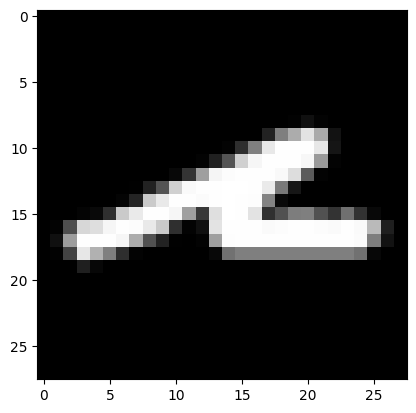

In [7]:
idx = 5
img = emnist_train.data[idx]
print("The number shown is the number: {}".format(emnist_train.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

In [8]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

## Training a DBN
From Knowledge of what we learnt duirng the course: 
- a Deep Belief Network is made by a stack of Restricted Boltzmann Machines, which are energy-based models;
- they are *unsupervised* deep learning architectures, whose goal is to learn the probability distribution that could have generated the training data (maximum-likelihood);
- this means they can be used to run both *forward* (bottom-up) and *backward* (top-down) passes through the architecture, to compute either hidden representations ("inference" over latent variables) or to generate prototypical examples of a specific class;
- they are trained using an algorithm called *contrastive divergence*, whose goal is to reduce the difference between the learned probability distribution and the true (empirical) one.

We now create a hierarchical generative model (Deep Belief Network) and train it in an unsupervised way on the MNIST dataset.

In [9]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=3,# contrastive divergence we can try increasing it to 2 or 3 to increse clarity of model
                learning_rate=0.001,#may be use wiser learning rate schedule instead of using constanting learning rate keeping learning decay as true may increase performance 
                learning_rate_decay=False,
                initial_momentum=0.5,# optimized already
                final_momentum=0.95,# optimized already
                weight_decay=0.0001,# optimized already
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [10]:
num_epochs = 50
batch_size = 125

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |3.5115     |0.1346       |6.7398   |0.1697     |
|20    |2.8477     |0.0998       |6.2177   |0.1663     |
|30    |2.6575     |0.0914       |6.1512   |0.1715     |
|40    |2.5549     |0.0816       |6.1038   |0.1783     |
|50    |2.4852     |0.0791       |6.0392   |0.1556     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |6.4872     |0.1595       |7.3829   |0.2664     |
|20    |5.0804     |0.1227       |6.4641   |0.1972     |
|30    |4.4544     |0.1108       |6.0274   |0.2114     |
|40    |4.1416     |0.1057       |5.7722   |0.1972     |
|50    |3.9668     |0.1031       |5.5922   |0.1798     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |4.1222     |0.1132       |11.5404   |0.3808     |
|20    |3.3583     |0.0862       |10.1030   |0.3391     |
|30    |3.0797

## Visualizing receptive fields

After training the network, we are now going to visualize the learned weights. In order to do so, we will plot some of the weights in a picture of the same size of the EMNIST images we used for training. In this way, we will see which parts of an image trigger the unit associated with a specific weight vector.

It will also be useful to apply a threshold on the learned weights, in order to make the plots less noisy. Finally, the values in different weigths could have different ranges, so we will use a `MinMaxScaler` from Scikit-Learn to make a meaningful comparison among the visualizations of different receptive fields.

In [11]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

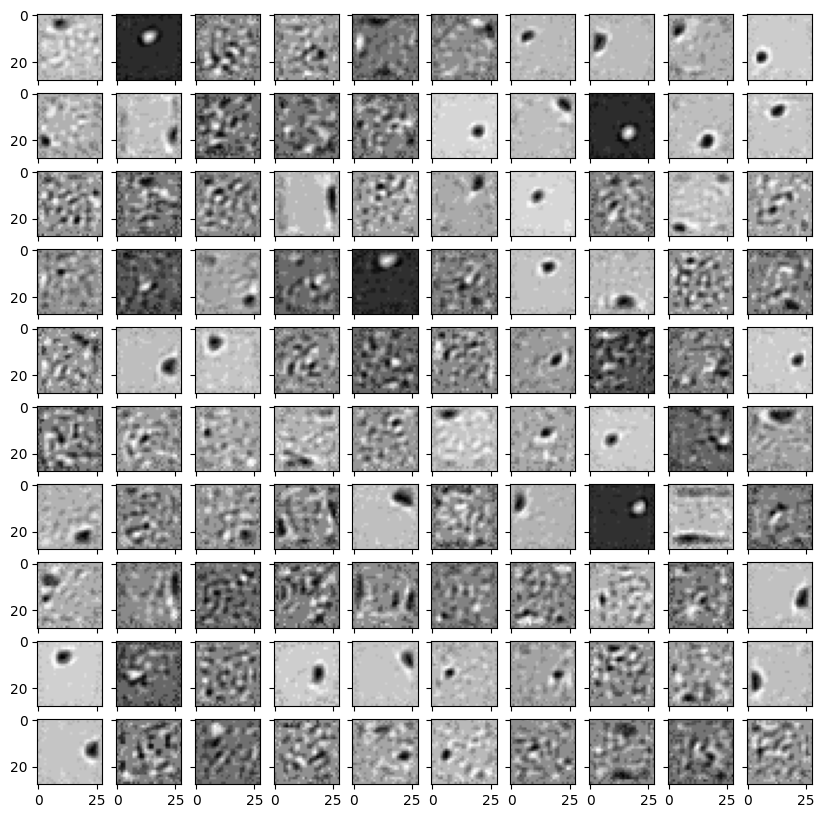

In [14]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

The weights in the second and third hidden layers have don't have the same dimensionality as EMNIST digits, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images.

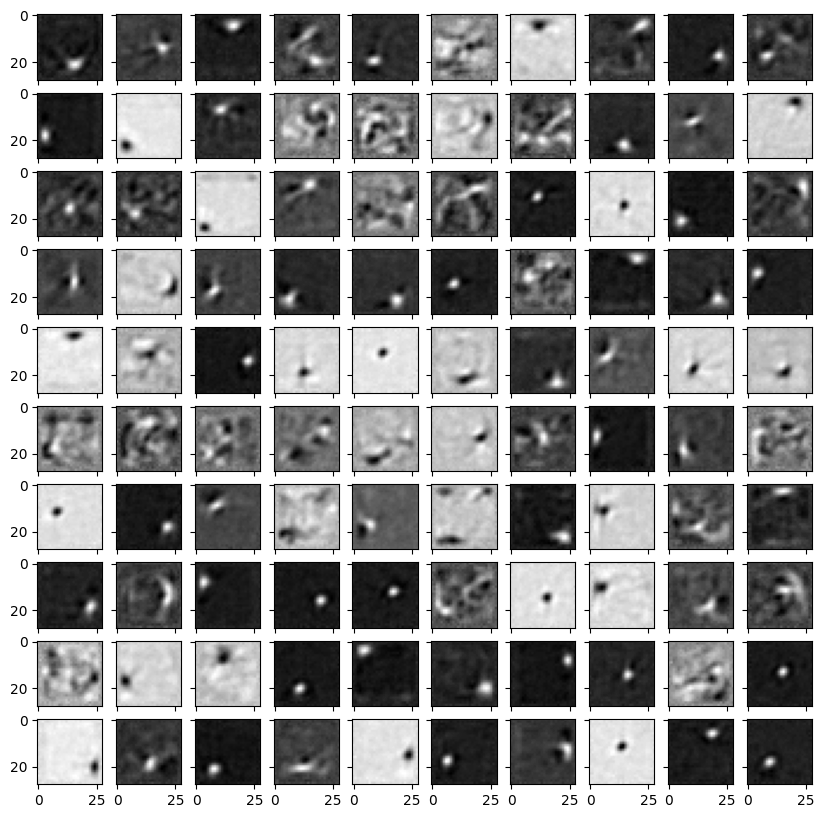

In [15]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

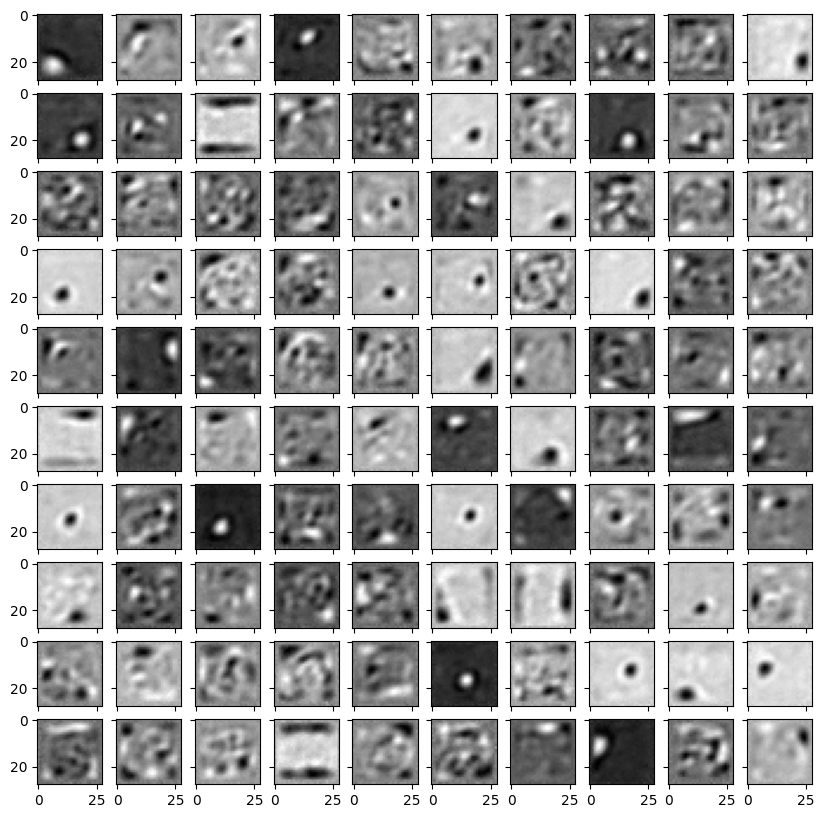

In [16]:
learned_weights_layer_1 = get_weights(dbn_emnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_emnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_emnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

## Clustering internal representations

Then, we want to examine the properties of the learned representations. Therefore, we will compute the centroid of the representations learned for each class, and see how close they are one to the other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM` contained in the `DBN`.

In [17]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

Of course, the representations computed using the second layer are computed using the ones from the first layer:

In [18]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [25]:
def get_mask(label):  # we use this function to filter by class
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [26]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [27]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

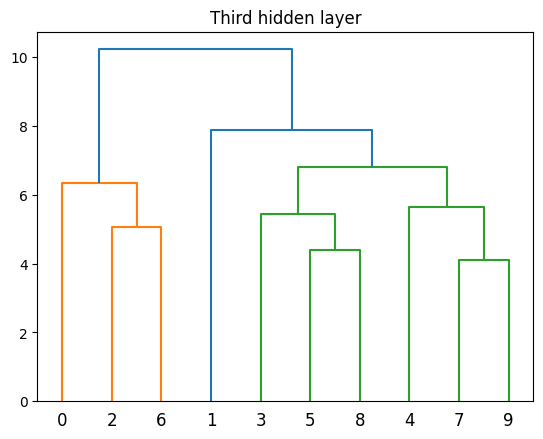

In [28]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Linear read-out

We can now extract the hidden representations of the data, by propagating the neuron's activations from the sensory (visible) layer in a bottom-up fashion, and try to lineary decode the content of the representations in a supervised way.

In [19]:
#class LinearModel(torch.nn.Module):
 # def __init__(self, last_layer_size):
    #super().__init__()
    #self.linear = torch.nn.Linear(last_layer_size, 47) # single layer classifier without any hidden layers which is a linear classifier to map the hidden 
    #representations at diff. levels of hierachy into supervised classes.Can be told as How good is 1st hidden layer to this entangled info of mnist digts 
    # to classify therm into 10 classes.
  #def forward(self, x):
   # return self.linear(x)
   
class LinearModel(torch.nn.Module):
    def __init__(self, last_layer_size, hidden_size=200):
        super().__init__()
        self.fc1 = torch.nn.Linear(last_layer_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, 47)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.linear(x)

In [20]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

In [21]:
def train(network, input, epochs=5000, early_stopping=False):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  best_loss = float("inf")
  best_weights = None
  patience = 10
  count_since_best = 0

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

    if early_stopping:
      # Track the best loss and store the model parameters if it's the best
      if loss < best_loss:
        count_since_best = 0
        best_loss = loss
        best_weights = network.state_dict()
      else:
        count_since_best += 1

      if count_since_best >= patience:
        network.load_state_dict(best_weights)
        print("Early stopping triggered. Best loss: {:.4f}".format(best_loss))
        break

In [22]:
train(linear1, hidden_repr_layer_1)
train(linear2, hidden_repr_layer_2)
train(linear3, hidden_repr_layer_3)

epoch :   1/5000, loss = 3.8562
epoch : 101/5000, loss = 3.7615
epoch : 201/5000, loss = 3.3790
epoch : 301/5000, loss = 2.6048
epoch : 401/5000, loss = 1.9834
epoch : 501/5000, loss = 1.6539
epoch : 601/5000, loss = 1.4707
epoch : 701/5000, loss = 1.3609
epoch : 801/5000, loss = 1.2860
epoch : 901/5000, loss = 1.2298
epoch : 1001/5000, loss = 1.1853
epoch : 1101/5000, loss = 1.1485
epoch : 1201/5000, loss = 1.1170
epoch : 1301/5000, loss = 1.0895
epoch : 1401/5000, loss = 1.0647
epoch : 1501/5000, loss = 1.0423
epoch : 1601/5000, loss = 1.0217
epoch : 1701/5000, loss = 1.0026
epoch : 1801/5000, loss = 0.9848
epoch : 1901/5000, loss = 0.9681
epoch : 2001/5000, loss = 0.9523
epoch : 2101/5000, loss = 0.9374
epoch : 2201/5000, loss = 0.9232
epoch : 2301/5000, loss = 0.9095
epoch : 2401/5000, loss = 0.8964
epoch : 2501/5000, loss = 0.8838
epoch : 2601/5000, loss = 0.8716
epoch : 2701/5000, loss = 0.8597
epoch : 2801/5000, loss = 0.8482
epoch : 2901/5000, loss = 0.8369
epoch : 3001/5000, l

In [30]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [31]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [32]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [34]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.7874467968940735

In [36]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.7966489195823669

In [37]:
compute_accuracy(predictions_test3, emnist_test.targets)
# The accuracy is increasing as we move higher in accuracy which makes sense, it suggests the neural network is building stronger and 
# more robust represntations in hierachical generative model,the increase in accuracy it could also be due to increase in hidden units is more in 3rd layer compared 
# to other 2 layers as we are projecting data into higher dimension space when compared to other 2 layers for example. 


#HW: Keep no of layers same for ex: 500,500,500 and see if tthe accuracy is still better like previous case scenario when layers increased.

0.7963297963142395

## Comparison with a feed-forward model

Let's now train a simple feed-forward neural network with the same structure of the DBN, in order to compare a non-linear model that is trained end-to-end to solve a classification task with a simple linear classifier that solves the same task using representations of input data learned in an *unsupervised* way.

In [40]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size, hidden_size=200):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.fc1 = torch.nn.Linear(third_hidden_layer_size, hidden_size)
    self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
    self.linear = torch.nn.Linear(hidden_size, 47)
    self.relu = torch.nn.ReLU()

  def forward(self, input):
    first_hidden_repr = self.relu(self.first_hidden(input))
    second_hidden_repr = self.relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = self.relu(self.third_hidden(second_hidden_repr))
    hidden_repr = self.relu(self.fc1(third_hidden_repr))
    hidden_repr = self.relu(self.fc2(hidden_repr))
    output = self.linear(hidden_repr)
    return output

In [41]:
ffnn = Feedforward(400, 500, 800).to(device)# ffnn called as feedforward neural network with same layers w.r.t to DBN to get fair comparision 

We choose the number of epochs to match the training time of the DBN and the readout layer combined.

In [43]:
train(ffnn, emnist_train.data.reshape((112800, 784)), epochs=1500)# takes more time than linear classifier since wwe are training entire linear model with 3 hidden layers using exact same funciton used for DBN
# we can count no of parameter weights similar to DBN model like 784*400+400*500*500*800+800*10 which is why it takes more time. 

epoch :   1/1500, loss = 3.8508


RuntimeError: CUDA out of memory. Tried to allocate 346.00 MiB (GPU 0; 4.00 GiB total capacity; 2.95 GiB already allocated; 0 bytes free; 3.41 GiB reserved in total by PyTorch)

In [23]:
predictions_ffnn = ffnn(emnist_test.data.reshape((10000, 784)))

In [24]:
compute_accuracy(predictions_ffnn, emnist_test.targets)

# we can say DBN and Feedforward gives same accuracy if compared with performance metric. However if we give noisy data how fast the performance drop can be
# characterised by stiochiometric terms. so we systematically test models using many levels of noise we can see how robust the model is with increase in pertubations
# with sensory data.

0.9400999546051025

## Robustness to noise

We will now inject some noise in the input images and see how much the representations learned by the DBN and the feed-forward network are robust to perturbations in the sensory signal.

Similarly to what happens in psychophysical experiments, this will allow to create a psychometric curve describing the decrease in classification accuracy with respect to the noise level.

In [25]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor
  # here check the sum if it is larger to 1 put it to 1 and if it is smaller than 0 put it to zero advanced version of 
  # noise function.

Let's see what a noisy image looks like:

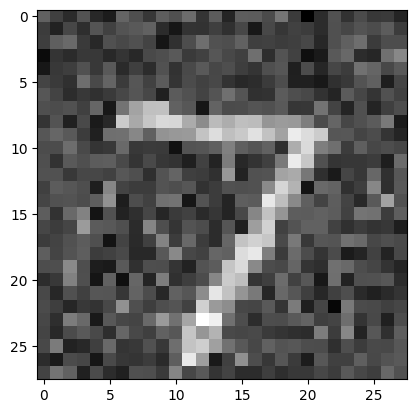

In [39]:
noise_level = 0.2
mnist_test_with_noise = inject_noise(emnist_test.data, noise_level)
__ = plt.imshow(mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")


We will now compute the hidden representations for the noisy images using the DBN. Then, we will use the read-out classifiers that we trained on the representations without noise to classify the noisy stimuli.

In [40]:
def get_accuracy_values_at_noise_level(noise_level):

  mnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy,emnist_test.targets)
  
  predictions_ffnn_noisy = ffnn(mnist_test_with_noise.reshape((10000, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, emnist_test.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [43]:
acc = get_accuracy_values_at_noise_level(0.6);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

# we can see ffnn is crashinh whereas DBN layers like in 3 rd is almost constant

Accuracy of H1 read-out: 0.795
Accuracy of H2 read-out: 0.878
Accuracy of H3 read-out: 0.896
Accuracy of FF network : 0.776


Let's create the psychometric curves for the DBN (at different levels of internal representations) and for the feed-forward network:

In [45]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

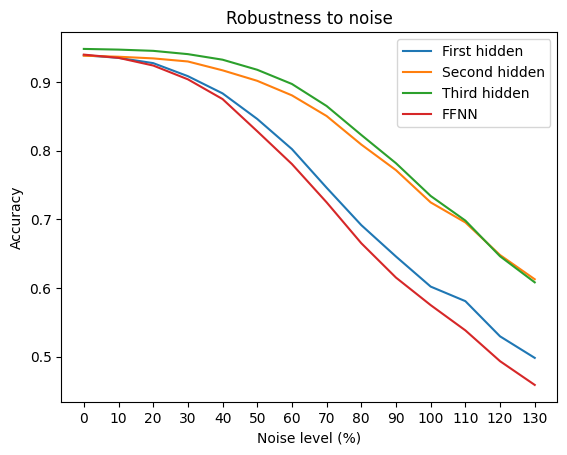

In [46]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)